# Characterizing the noise in dMRI measurements in multiple b-values

In our [PLoS One article](http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0123272) we examined model 
error and . We have been [asked](http://journals.plos.org/plosone/article/comment?id=info%3Adoi%2F10.1371%2Fannotation%2Fdc564667-fa22-4d34-8ff1-09f851c47771) whether using RMSE as a metric is a good idea in cases in which the SNR is low, given that the signal is distributed as a Rician distribution. 

Issues related to the Rician distribution are already well-known. The original poster points to literature about the noise in places where the signal is essentially zero (the background), but others have already pointed out issues related to locations where the signal is non-zero, and of physiological interest (e.g., Jones and Basser, 2004). 

Here, we show that ... (To be continued)

In [1]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Download data:

In [2]:
import urllib as url
import os.path as op

top_url = 'https://stacks.stanford.edu/file/druid:ng782rw8378/'

# Download test-retest data in 3 b-values
for s in [1, 2]:
    for b in [1000, 2000, 4000]:
        for ext in ['.nii.gz', '.bvecs', '.bvals']:
            fname = 'SUB1_b%s_%s%s'%(b,s, ext)
            if not op.exists('./data/' + fname):
                url.request.urlretrieve(op.join(top_url, fname), './data/' + fname)
    
# Download a white matter segmentation:
for fname in ["SUB1_aparc-reduced.nii.gz", "SUB1_t1.nii.gz"]:
    if not op.exists('./data/' + fname):
        url.request.urlretrieve(op.join(top_url, fname), './data/' + fname)


### Create a mask of white matter from a Freesurfer segmentation:

In [3]:
seg_img = nib.load('data/SUB1_aparc-reduced.nii.gz')
seg = seg_img.get_data()
# Detect the white matter portions as a mask: 
mask = (seg == 1) | (seg == 2)

In [4]:
import nibabel as nib
import dipy.core.gradients as dpg
from scipy import stats

### Define a couple of utility functions:

In [5]:
from dipy.align.imaffine import AffineMap

def resample_volume(moving, static):
    """ 
    Resample a nifti image into the space of another nifti image
    
    Parameters
    ----------
    moving : Nifti1Image
        The 'source' image.
    static : Nifti1Image
        The 'target' image.
        
    Returns
    -------
    resampled_img : Nifti1Image
       The source data in the target space, with the target affine
    """
    affine_map = AffineMap(np.eye(4),
                           static.shape[:3], static.affine, 
                           moving.shape, moving.affine)
    
    resampled = affine_map.transform(moving.get_data())
    return nib.Nifti1Image(resampled, static.get_affine())


In [6]:
def load_data(b):
    """ Read test-retest dMRI data from files"""
    gtab1 = dpg.gradient_table('data/SUB1_b%s_1.bvals'%b, 
                              'data/SUB1_b%s_1.bvecs'%b)

    gtab2 = dpg.gradient_table('data/SUB1_b%s_2.bvals'%b, 
                              'data/SUB1_b%s_2.bvecs'%b)

    img1 = nib.load('data/SUB1_b%s_1.nii.gz'%b)
    img2 = nib.load('data/SUB1_b%s_2.nii.gz'%b)

    data1 = img1.get_data()
    data2 = img2.get_data()
    
    return gtab1, gtab2, data1, data2

In [7]:
def calc_diff(data1, data2, gtab1, gtab2, mask):
    """ Calculate test-retest difference for every measurement """
    data1_b = data1[mask][..., ~gtab1.b0s_mask]
    data2_b = data2[mask][..., ~gtab2.b0s_mask]
    diff = data1_b - data2_b
    return diff

In [8]:
def prettify(fig_list, ax_list):
    for fig, ax in zip(fig_list, ax_list):
        fig.set_size_inches([8, 8])
        ax.grid("on", linestyle="--")
        ax.legend()

### Resample the T1-weighted volume to the DWI resolution:

In [9]:
t1_img = nib.load('data/SUB1_t1.nii.gz')
t1_resamp = resample_volume(t1_img, nib.load('data/SUB1_b1000_1.nii.gz'))
t1 = t1_resamp.get_data()

### Refine the WM mask using the distribution of mean diffusivity:

To avoid including voxels that contain partial volume of CSF, we further refine the white matter mask, based on the distribution of MD. This is based on the procedure used by Jeurissen et al. (2012). As in our original paper, we use the measurement at b=2000 $s/mm^2$.

In [10]:
import dipy.reconst.dti as dti
gtab1, gtab2, data1, data2 = load_data(2000)

ten_model = dti.TensorModel(gtab1)
ten_fit = ten_model.fit(data1, mask=mask)

In [11]:
MD = ten_fit.md

In [12]:
IQR = (stats.scoreatpercentile(MD[mask], 75) -
       stats.scoreatpercentile(MD[mask], 25))
co = np.median(MD[mask]) + 2 * IQR
co_idx = np.where(MD > co)

In [13]:
new_mask = np.copy(mask)
new_mask[co_idx] = 0
mask = new_mask

### Characterize the signals

First, we plot the distributions of signals in these data. 

For each voxel, we extract the diffusion-weighted signals (relative to the non diffusion-weighted signal) and we plot the distribution of these across all directions and all voxels in the white matter.

We also want to characterize the Gaussianity of the signals, so we plot the distribution of the kurtosis in each 
voxel:

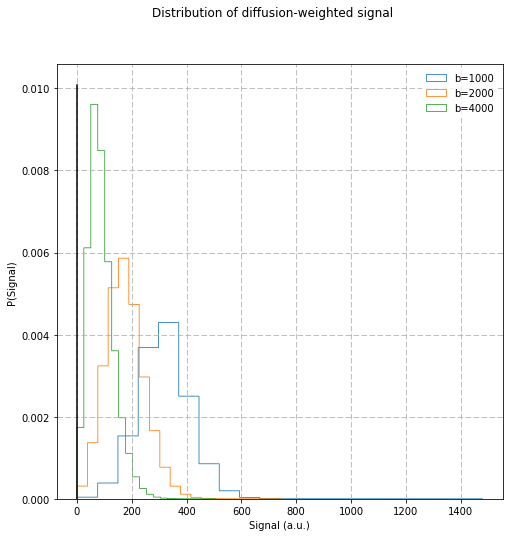

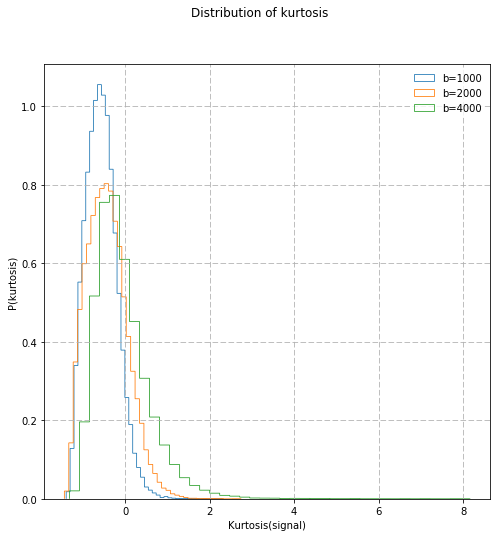

In [14]:
fig_sig, ax_sig = plt.subplots(1)
fig_kurt, ax_kurt = plt.subplots(1)

for b in [1000, 2000, 4000]:
    gtab1, gtab2, data1, data2 = load_data(b)
    sig_d = (data1[..., ~gtab1.b0s_mask])# / 
            #(np.mean(data1[..., gtab1.b0s_mask], -1)[..., None]))

    # Relative diffusion-weighted signal larger than 1 is an artifact:
    #sig_d[sig_d > 1] = 1

    # Histogram of the diffusion-weighted normalized signals:
    ax_sig.hist(sig_d[mask].ravel(), 
                 histtype='step', bins=20, normed=True, label='b=%s'%b)
    
    ax_sig.set_xlabel("Signal (a.u.)")
    ax_sig.set_ylabel("P(Signal)")
    fig_sig.suptitle("Distribution of diffusion-weighted signal")

    # And the kurtosis:
    ax_kurt.hist(stats.kurtosis(sig_d[mask], -1), 
                 histtype='step', bins=40, normed=True, label='b=%s'%b)
    
    ax_kurt.set_xlabel("Kurtosis(signal)")
    ax_kurt.set_ylabel("P(kurtosis)")
    fig_kurt.suptitle("Distribution of kurtosis")
    
# Emphasize the zero crossing, so that it's clear how 
# much of the data dips below zero:
ax_sig.plot([0, 0], [0, ax_sig.get_ylim()[1]], 'k')

prettify([fig_sig, fig_kurt], [ax_sig, ax_kurt])

### Characterizing the distribution of errors

One way to address the question of whether the errors are distributed in a Gaussian manner is to assess the kurtosis of the test-retest differences in each voxel. In voxels in which this distribution is Gaussian, the kurtosis will be approximately 0 (using Fisher's definition). 

We also want to know whether there are parts of the white matter that are particularly susceptible to large deviations  from Gaussian. 

/Users/arokem/anaconda/lib/python3.5/site-packages/matplotlib/image.py:373: RuntimeWarning: invalid value encountered in less
  rgba[..., 1] = A < 0  # under data
/Users/arokem/anaconda/lib/python3.5/site-packages/matplotlib/image.py:374: RuntimeWarning: invalid value encountered in greater
  rgba[..., 2] = A > 1  # over data


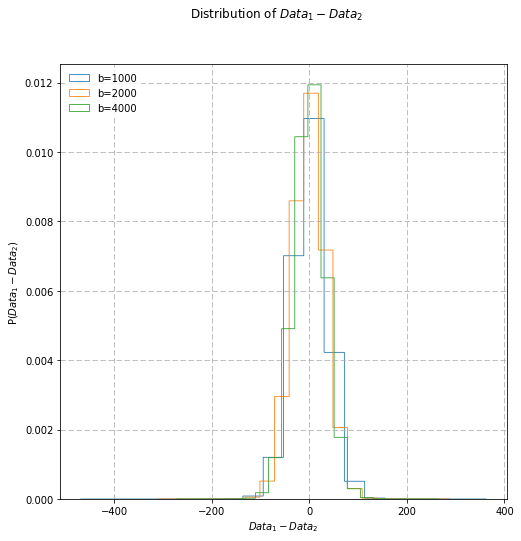

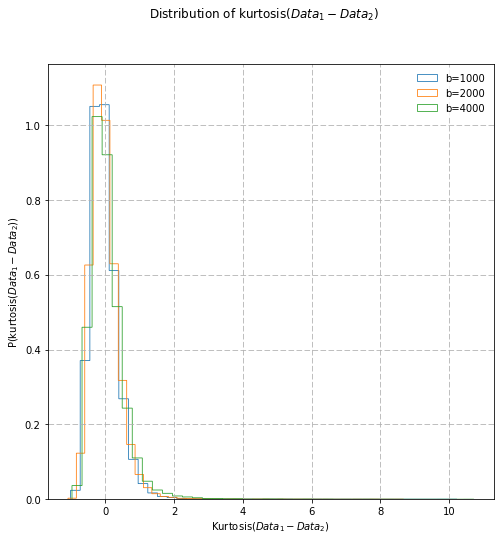

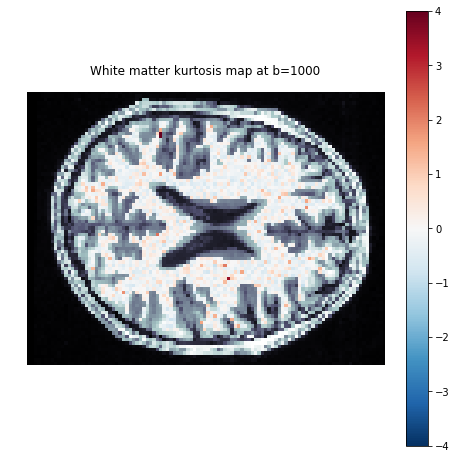

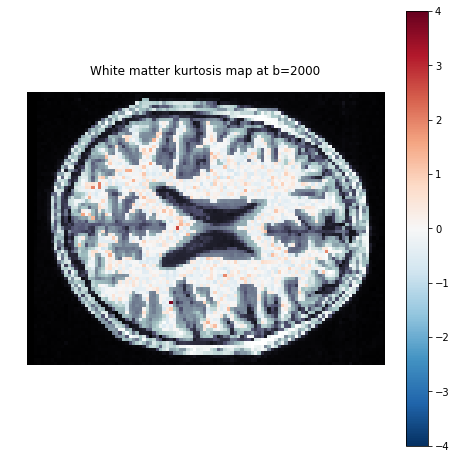

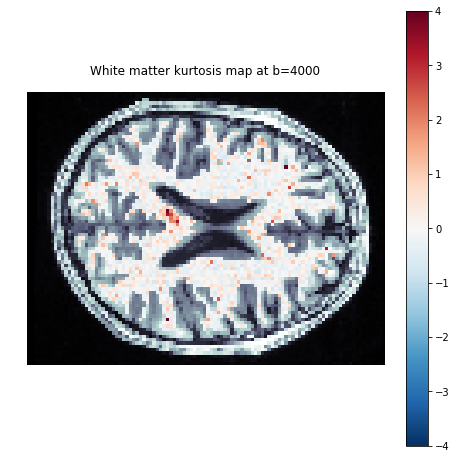

In [15]:
fig_diff, ax_diff = plt.subplots(1)
fig_kurtosis, ax_kurtosis = plt.subplots(1)

for b in [1000, 2000, 4000]:
    gtab1, gtab2, data1, data2 = load_data(b)

    # Calculate the measurement-by-measurement test-retest 
    # reliability:
    diff = calc_diff(data1, data2, gtab1, gtab2, mask)

    # Histogram of the differences:
    ax_diff.hist(diff.ravel(), histtype='step', bins=20, 
                 normed=True, label='b=%s'%b)
    ax_diff.set_xlabel("$Data_1 - Data_2$")
    ax_diff.set_ylabel("P($Data_1 - Data_2$)")
    fig_diff.suptitle("Distribution of $Data_1 - Data_2$")
    
    k = stats.kurtosis(diff, axis=1)
    ax_kurtosis.hist(k, bins=40, normed=True, histtype='step',
                     label='b=%s'%b)
    
    ax_kurtosis.set_xlabel("Kurtosis($Data_1 - Data_2$)")
    ax_kurtosis.set_ylabel("P(kurtosis($Data_1 - Data_2$))")
    fig_kurtosis.suptitle("Distribution of kurtosis($Data_1 - Data_2$)")

    # What is the spatial distribution of the kurtosis?
    vol = np.ones(mask.shape[:3]) * np.nan
    vol[mask] = k
    fig, ax = plt.subplots(1)
    ax.matshow(t1[:, :, 40], cmap='bone')
    im = ax.matshow(vol[:, :, 40], vmin=-4, vmax=4, cmap='RdBu_r')
    plt.colorbar(im)
    fig.set_size_inches([8, 8])
    ax.set_title("White matter kurtosis map at b=%s"%b)
    ax.set_axis_off()

prettify([fig_diff, fig_kurtosis], [ax_diff, ax_kurtosis])

### Is it reasonably IID?

Another aspect of using RMSE is that we would ideally want all the signals to be IID. 

Here, we examine whether there is a systematic dependence between the mean signal (across the two measurements) and the standard deviation of this. 

We can see that really low signals do have squashed distributions (when the signal is 0, the STD is also essentially 0), but that affects only a small range of signal values (I am not sure if that's actually a good thing...).


(0, 2000)

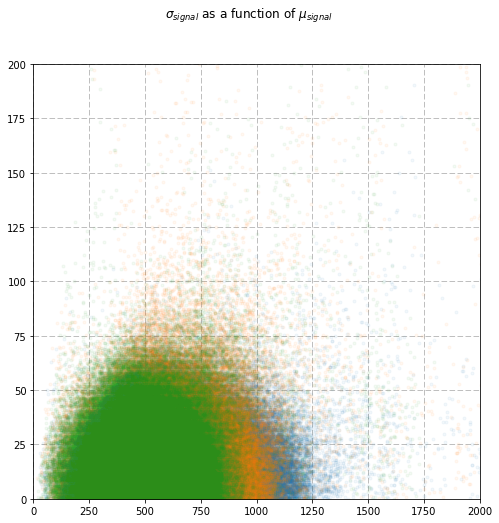

In [16]:
fig_scatter, ax_scatter = plt.subplots(1)

for b in [1000, 2000, 4000]:
    gtab1, gtab2, data1, data2 = load_data(b)
    stack_data = np.vstack([data1[..., gtab1.b0s_mask][mask].ravel(), 
                            data2[..., gtab2.b0s_mask][mask].ravel()])

    std_data = np.std(stack_data, 0)
    mean_data = np.mean(stack_data, 0)
    
    # Is there a systematic relationship between standard deviation 
    # and mean signal?
    ax_scatter.plot(mean_data, std_data, '.', alpha=0.05)
    
    fig_scatter.suptitle("$\sigma_{signal}$ as a function of $\mu_{signal}$")
    
fig_scatter.set_size_inches([8, 8])
ax_scatter.grid("on", linestyle="--")

# Zoom in on the part that contains most of the data:
ax_scatter.set_ylim([0, 200])
ax_scatter.set_xlim([0, 2000])

### References 

1. Jones D and Basser P.J. (2004). “Squashing Peanuts and Smashing Pumpkins”: How
   Noise Distorts Diffusion-Weighted MR Data. Magnetic Resonance in Medicine 52:979-993.

2. Jeurissen B, Leemans A, Tournier, J-D, Jones, DK and Sijbers J
   (2013). Investigating the prevalence of complex fiber configurations in white
   matter tissue with diffusion magnetic resonance imaging. Human Brain Mapping  
   34:2747-2766, doi: 10.1002/hbm.2209